# Rice (Cammeo and Osmancik) Classification
## Deliverable 3
#### Sai Bagewadi

## Summary of the Project

**Project dataset description:** Among the certified rice grown in TURKEY, the Osmancik species, which has a large planting area since 1997 and the Cammeo species grown since 2014 have been selected for the study. When looking at the general characteristics of Osmancik species, they have a wide, long, glassy and dull appearance. When looking at the general characteristics of the Cammeo species, they have wide and long, glassy and dull in appearance. A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.



all necessary Import statements are added to beigin with. Also, Added random_seed as variable and same will be used trhoughout the project for consistent results.
    
    
**NOTE:** *This code file runs in 3.5 minutes in total.* 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras as keras
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import SGDRegressor 
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer as Imputer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score,recall_score,f1_score,accuracy_score

from keras import optimizers,losses,metrics
from keras.models import Sequential
from keras.layers import Dense

import sklearn as skl
random_seed = 1
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
np.set_printoptions(precision=2)

### 1. Data Loading

use Pandas read function to read the excel file from Website. The alternate way to load data using csv local file is also made available in commented code just in case Web URL doces not work.

In [2]:
#data_set = pd.read_csv("Rice_Osmancik_Cammeo_Dataset.csv")
data_set = pd.read_excel("https://www.muratkoklu.com/datasets/vtdhnd03.php",sheet_name=0)  
#sheet: Rice_Osmancik_Cammeo_Dataset at pos 0

### 2. Examine Data

Once read, look at .info() output to learn quick facts about data types, names and where there are null/empty values
In this case, below, we have clean data with all numerical data except for the CLASS which is object Type and is our Y for this project. Also total non-null count of all features is same as total range index of table and that is a good sign that data is clean.

In [3]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          3810 non-null   int64  
 1   PERIMETER     3810 non-null   float64
 2   MAJORAXIS     3810 non-null   float64
 3   MINORAXIS     3810 non-null   float64
 4   ECCENTRICITY  3810 non-null   float64
 5   CONVEX_AREA   3810 non-null   int64  
 6   EXTENT        3810 non-null   float64
 7   CLASS         3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


Use head() to look at top few records of actual data from the table. The data here provides me inforamtion that it has area, perimeter, major & minor axis length, eccentricity, convex_area and Extent fields as well. All in all, It can be seen that we have all numeric features using which we need to predict the target CLASS

In [4]:
data_set.head()

AREA   PERIMETER   MAJORAXIS  MINORAXIS  ECCENTRICITY  CONVEX_AREA  \
0  15231  525.578979  229.749878  85.093788      0.928882        15617   
1  14656  494.311005  206.020065  91.730972      0.895405        15072   
2  14634  501.122009  214.106781  87.768288      0.912118        14954   
3  13176  458.342987  193.337387  87.448395      0.891861        13368   
4  14688  507.166992  211.743378  89.312454      0.906691        15262   

     EXTENT   CLASS  
0  0.572896  Cammeo  
1  0.615436  Cammeo  
2  0.693259  Cammeo  
3  0.640669  Cammeo  
4  0.646024  Cammeo

use value_counts() function to identify the various categories available for the CLASS feature.
In this case, we can see that there are exactly two categories under CLASS feature -  Osmancik and Cammeo.

In [5]:
data_set['CLASS'].value_counts()

Osmancik    2180
Cammeo      1630
Name: CLASS, dtype: int64

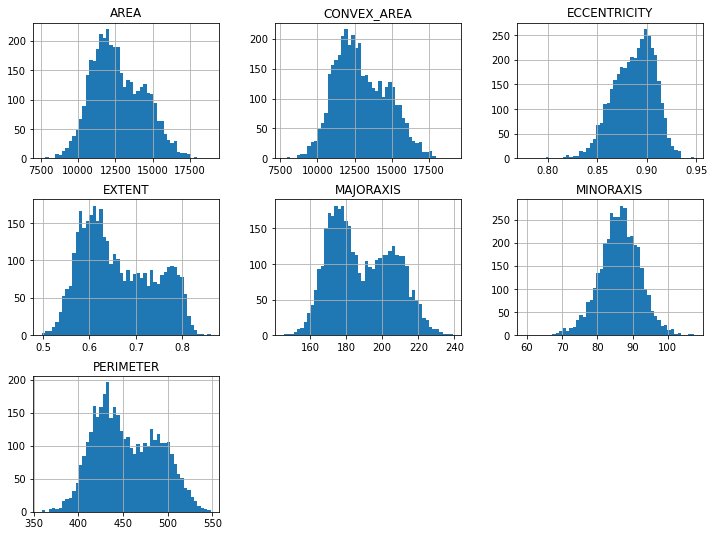

In [6]:
_=data_set.hist(bins=50,figsize=(12,9))

Above data tells me that features are on varied scales so feature scaling needs to be performed.

### 3. Create a Test Set
 Creating test set at this time avoids any data snooping and thus avoids impact of data preprocessing on test data so the model can be more reliable as it is tested against actual data than pre-processed data. Let's use 20% of data as test and then set random_state=1 to allow for reproducible/controlled data shuffling.
 

In [7]:
train_set,test_set = train_test_split(data_set, test_size=0.2, random_state=random_seed)
print("trainset: \n",train_set.count())
print("\ntestset: \n",test_set.count())

trainset: 
 AREA            3048
PERIMETER       3048
MAJORAXIS       3048
MINORAXIS       3048
ECCENTRICITY    3048
CONVEX_AREA     3048
EXTENT          3048
CLASS           3048
dtype: int64

testset: 
 AREA            762
PERIMETER       762
MAJORAXIS       762
MINORAXIS       762
ECCENTRICITY    762
CONVEX_AREA     762
EXTENT          762
CLASS           762
dtype: int64


### 4. Data Exploration

At this point take a copy of training data set into another temporary data set to explore with and not disturb the train data set.

In [8]:
explore_data_set = train_set.copy()

As we know, most Machine learning techniques would like to operate on numerical values than objects/strings. So, we can derive isCammeo feature as shown below. As we have inspected data and we know that there are only two possible values for CLASS, it is ok to add a feature this way. If not, OneHotEncoding should be the to-go approach.

In [9]:
explore_data_set["ISCAMMEO"] = np.where(explore_data_set['CLASS'] == 'Cammeo', 1,0)
explore_data_set.head()

AREA   PERIMETER   MAJORAXIS  MINORAXIS  ECCENTRICITY  CONVEX_AREA  \
2270  10780  407.157990  163.393021  85.594276      0.851807        11096   
111   12471  445.373993  184.992065  86.859756      0.882915        12688   
1792  11580  428.709015  173.488083  86.639183      0.866374        11921   
133   13507  468.239014  197.509247  87.929596      0.895435        13735   
3413  10956  422.171997  178.351868  79.157143      0.896113        11131   

        EXTENT     CLASS  ISCAMMEO  
2270  0.673750  Osmancik         0  
111   0.671784    Cammeo         1  
1792  0.747772  Osmancik         0  
133   0.577222    Cammeo         1  
3413  0.573132  Osmancik         0

We need to next take a look at correlation matrix to identify how each feature is related to Y(CLASS or in other words isCammeo). We happen to find that MAJORAXIS is the best feature that we can focus on.

In [10]:
corr_mtx = explore_data_set.corr()
print(corr_mtx['ISCAMMEO'].sort_values(ascending=False))
#best_feature = 'MAJORAXIS'

ISCAMMEO        1.000000
MAJORAXIS       0.828814
PERIMETER       0.807813
CONVEX_AREA     0.752823
AREA            0.748712
ECCENTRICITY    0.585164
MINORAXIS       0.371390
EXTENT         -0.110377
Name: ISCAMMEO, dtype: float64


Now, Lets see if Major Axis to Minor axis ratio has an even better correlation than MajorAxis alone. This can identify relation if leaner grains relates well to being a CAMMEO grain. Also, lets do a relation on Major Axis to Perimeter which will also derive similar information but with different params

In [11]:
explore_data_set["MinorToMajorAxisRatio"] = explore_data_set["MINORAXIS"]  /  explore_data_set["MAJORAXIS"]
explore_data_set["MajorAxistoPerimeterRatio"] = explore_data_set["MAJORAXIS"]  /  explore_data_set["PERIMETER"]

In [12]:
corr_mtx = explore_data_set.corr()
print(corr_mtx['ISCAMMEO'].sort_values(ascending=False))
#best_feature = 'MAJORAXIS'

ISCAMMEO                     1.000000
MAJORAXIS                    0.828814
PERIMETER                    0.807813
CONVEX_AREA                  0.752823
AREA                         0.748712
ECCENTRICITY                 0.585164
MajorAxistoPerimeterRatio    0.528893
MINORAXIS                    0.371390
EXTENT                      -0.110377
MinorToMajorAxisRatio       -0.590766
Name: ISCAMMEO, dtype: float64


Now, lets generate scatter plots to see if we can find any linear as well as non-linear correlations that exists.

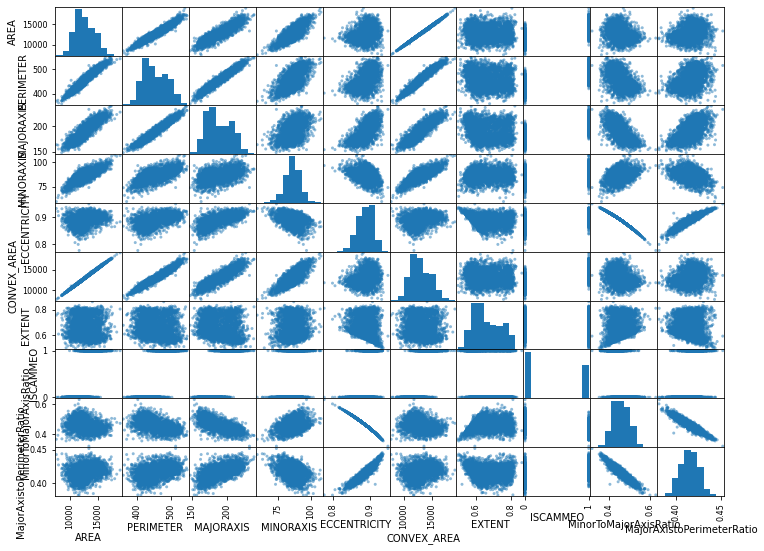

In [13]:
_=scatter_matrix(explore_data_set,figsize=(12,9))

Now, Lets seperate features from target. CLASS is target, that will be coded to 1 or 0 based on whether grain is of type Cammeo or not respectively.

In [14]:
X_train = train_set.drop("CLASS",axis=1)
y_train = train_set["CLASS"].copy()
y_train = 1*(y_train=="Cammeo")
X_test = test_set.drop("CLASS",axis=1)
y_test = test_set["CLASS"].copy()
y_test = 1*(y_test =="Cammeo")

print(X_train.head())

       AREA   PERIMETER   MAJORAXIS  MINORAXIS  ECCENTRICITY  CONVEX_AREA  \
2270  10780  407.157990  163.393021  85.594276      0.851807        11096   
111   12471  445.373993  184.992065  86.859756      0.882915        12688   
1792  11580  428.709015  173.488083  86.639183      0.866374        11921   
133   13507  468.239014  197.509247  87.929596      0.895435        13735   
3413  10956  422.171997  178.351868  79.157143      0.896113        11131   

        EXTENT  
2270  0.673750  
111   0.671784  
1792  0.747772  
133   0.577222  
3413  0.573132  


In [15]:
print(y_train.head())

2270    0
111     1
1792    0
133     1
3413    0
Name: CLASS, dtype: int32


In [16]:
print(X_test.head())

       AREA   PERIMETER   MAJORAXIS   MINORAXIS  ECCENTRICITY  CONVEX_AREA  \
1907   9843  383.115997  154.950317   81.356834      0.851071        10024   
321   14400  481.506012  193.782959   96.516190      0.867141        14876   
372   13272  471.899994  201.494690   84.153793      0.908609        13492   
1026  16413  510.109985  210.555115  100.121895      0.879708        16665   
2823  12605  445.692993  183.269257   88.236824      0.876468        12787   

        EXTENT  
1907  0.702269  
321   0.683891  
372   0.565729  
1026  0.599890  
2823  0.617589  


In [17]:
print(y_test.head())

1907    0
321     1
372     1
1026    1
2823    0
Name: CLASS, dtype: int32


### Handle missing data
As there are no missing values in the dataset, we do not have to worry about missing values but if we had missing values, it is important that we either get rid of samples, get rid of the feature or replace nulls with 0, mean, median as applicable using something like a SimpleImputer from Sklearn.

### Add Custom class to add additional Attributes
Add additional features MinorToMajorAxisRatio as well as MajorAxistoPerimeterRatio that we analyzed during Data validation above
explore_data_set["MinorToMajorAxisRatio"] = explore_data_set["MINORAXIS"]  /  explore_data_set["MAJORAXIS"]
explore_data_set["MajorAxistoPerimeterRatio"] = explore_data_set["MAJORAXIS"]  /  explore_data_set["PERIMETER"]

In [18]:
class AddDerivedFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self,addAdditionalFeatures=True):
        self.MINORAXIS_ix,self.MAJORAXIS_ix,self.PERIMETER_ix = 3,2,1
        self.addAdditionalFeatures = addAdditionalFeatures
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        if self.addAdditionalFeatures:
            MinorToMajorAxisRatio = (X[:, self.MINORAXIS_ix] / X[:, self.MAJORAXIS_ix]).reshape(-1,1)
            MajorAxistoPerimeterRatio = (X[:, self.MAJORAXIS_ix] / X[:, self.PERIMETER_ix]).reshape(-1,1)
            return np.hstack([X,MinorToMajorAxisRatio,MajorAxistoPerimeterRatio])
        else:
            return X
        

In [19]:
#FeatureAdder = AddDerivedFeatures(addAdditionalFeatures = True)
#X_train_with_Extra_Features = FeatureAdder.transform(X_train.values)
#print(X_train.head(1))
#print(X_train_with_Extra_Features[0,:])


### 5. Data Wrangling
preprocess the data using Pipelines. We use imputer as median. It should have no impact as data is free of nulls. We then added the derivedfeatures using "FeatureDeriver" and finally added standard scaler as we noticed all feautres vary in their scale wildly.

In [20]:
myPipeLine = Pipeline(steps=[
                            ('imputer',Imputer(strategy="median")), # imputer does nothing as there are no nulls in dataset
                             ('FeatureDeriver',AddDerivedFeatures(addAdditionalFeatures = True)),
                             ('std_scaler',StandardScaler())
    
])

X_train_processed = myPipeLine.fit_transform(X_train)
X_test_processed = myPipeLine.fit_transform(X_test)
print(X_train.head(1))
print(X_train_processed[0,:])


       AREA  PERIMETER   MAJORAXIS  MINORAXIS  ECCENTRICITY  CONVEX_AREA  \
2270  10780  407.15799  163.393021  85.594276      0.851807        11096   

       EXTENT  
2270  0.67375  
[-1.09 -1.33 -1.46 -0.11 -1.71 -1.04  0.16  1.63 -1.37]


### 6. Identify Validation Method
As computational time is not an issue and dataset is considered small, We will go with Cross Validation.


### 7. Model Selection
   Let's experiment with various Binary Classifiers available and fine tune the best of them 
1. Logistic Regression (Classification Model)
2. DecisionTree Classifier
3. RandomForest Classifier
4. Gaussian Naive Bayes classifier


Below, We will use all the classifiers listed above with some static hyperparms to get a better understanding on the classifier that works best for our data. We use cross_val_score function to achieve it. we then identify mean of all the scores for each classifier and plot them. This data should give us fair idea about best Data model or a handful of models that can be further tuned to achieve best results.


In [21]:
logistic_classifier = SGDClassifier(eta0=0.001,max_iter=10000, tol=0.01, random_state=random_seed,loss='log')
tree_classifier = DecisionTreeClassifier(random_state=random_seed)
RandomForest_classifier = RandomForestClassifier(n_estimators=100,random_state=random_seed)
gnb_classifier = GaussianNB()

In [22]:
#Perform the cross validation for various models under test

print("train the Logistic model")
logistic_scores = cross_val_score(logistic_classifier, X_train_processed, y_train,scoring="f1", cv=10)
print("Logistic model Training complete")
print("train the DecisionTreeClassifier model")
treeclassifier_scores = cross_val_score(tree_classifier, X_train_processed, y_train,scoring="f1", cv=10)
print("DecisionTreeClassifier model Training complete")
print("train the RandomForestClassifier model")
RandomForestClassifier_scores = cross_val_score(RandomForest_classifier, X_train_processed, y_train,scoring="f1", cv=10)
print("RandomForestClassifier model Training complete")
print("train the gnb model")
gnb_scores = cross_val_score(gnb_classifier, X_train_processed, y_train,scoring="f1", cv=10)
print("gnb model Training complete")

train the Logistic model
Logistic model Training complete
train the DecisionTreeClassifier model
DecisionTreeClassifier model Training complete
train the RandomForestClassifier model
RandomForestClassifier model Training complete
train the gnb model
gnb model Training complete


In [23]:
#average of f1 scores
logistic_average_MEAN = logistic_scores.mean()
treeclassifier_average_MEAN = treeclassifier_scores.mean()
RandomForestClassifier_average_MEAN = RandomForestClassifier_scores.mean()
gnb_average_MEAN = gnb_scores.mean()


In [24]:
#Plotting
x = [1,2,3,4]
model_names = ["logistic","DTreeclsfr","Forestclsfr","gnb"]
All_MEANs = np.array([logistic_average_MEAN,
                      treeclassifier_average_MEAN,
                      RandomForestClassifier_average_MEAN,
                      gnb_average_MEAN])
print("\n\n\n All Means: ")
print(['{:.2%}'.format(item) for item in All_MEANs])




 All Means: 
['90.98%', '86.61%', '90.15%', '91.38%']


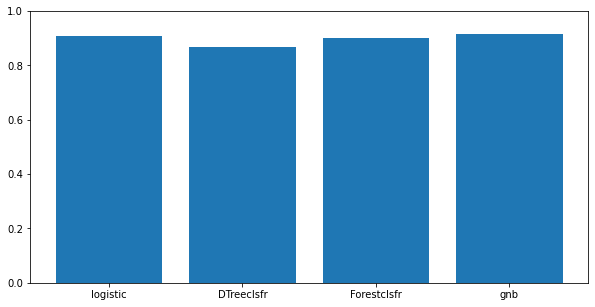

In [25]:
plt.figure(figsize=(10,5))
plt.bar(x, All_MEANs)
plt.xticks(x, model_names)
plt.ylim(top=1)
plt.show()

### 8 . Fine Tune Selected Model and test it
Looking at Mean plot above, it is evident that the best model is "Gaussian Naive Bayes" and is the selected Model for this problem. RandomForrestClassifier as well as SGDClassifier are not bad as well and can be explored as needed.

#### 8.1 Fine tune Gaussian Naive Bayes

   There are two approaches to fine tune: Systematic grid search using GridSearchCV and RandomizedSearchCV. As our datasize is small, we can use GridSearchCV and experiment with HyperParams. 

In [26]:
param_grid = [{'var_smoothing':[0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,
                                0.001,0.01,0.15,0.1,0.2,0.25,0.3,0.35,0.4,0.5,1]}]
gnb = GaussianNB()
grid_search = GridSearchCV(gnb,param_grid,cv=10,scoring='f1')
grid_search.fit(X_train_processed, y_train)
print(grid_search.best_params_)

{'var_smoothing': 0.3}


Once the best Hyper parameter(s) is/are identified, we use it to build our model,train and test it.

In [27]:
gnbmodel = grid_search.best_estimator_
gnbmodel.fit(X_train_processed,y_train.squeeze())
h_train = gnbmodel.predict(X_train_processed)
h_test = gnbmodel.predict(X_test_processed)
ca_train = accuracy_score(np.squeeze(y_train),h_train)
ca_test = accuracy_score(np.squeeze(y_test),h_test)
print("Training Accuracy: {0:.2%}".format(ca_train))
print("Testing Accuracy: {0:.2%}".format(ca_test))
print("Y_test:", np.squeeze(y_test).values[:30])
print("h_test:", h_test[:30])
print("shape of y_test:", y_test.shape)
print("shape of h_test:", h_test.shape)

Training Accuracy: 92.88%
Testing Accuracy: 92.26%
Y_test: [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1]
h_test: [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0]
shape of y_test: (762,)
shape of h_test: (762,)


Now that we have the h_test and y_test, build the confusion matrix that provides visual representation of false positives, false negatives, true positives and true negatives. Next, derive Precision, recall and f1 scores. While Precision score tells you  percentage of predicted positives that are correctly classified. recall gives you percentage of actual positives that are correcly classified.

In [28]:
gnbcf_test = confusion_matrix(y_test,h_test)
gnbps=precision_score(y_test,h_test)
gnbrs = recall_score(y_test,h_test)
gnbf1 = f1_score(y_test,h_test)
print(gnbcf_test)
print("ps: {0:.2%}".format(gnbps))
print("rs: {0:.2%}".format(gnbrs))
print("f1: {0:.2%}".format(gnbf1))

[[386  22]
 [ 37 317]]
ps: 93.51%
rs: 89.55%
f1: 91.49%


#### 8.2 FineTune SGDClassifier
Now lets tune the SGD Classifier the same way as above and this time, we have more hyper parameters to experiment with. Finally, use best hyper parameters to build model and calculate the metrics.


In [29]:
param_grid = [{'learning_rate':['invscaling','adaptive'],
               'eta0':[0.000001,0.000003,0.00001,0.00003,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.15,0.2,0.25,0.3,0.9],
               'max_iter':[100,200,300,400,500,1000,5000,10000]}]
sgd = SGDClassifier(tol=0.01, random_state=random_seed,loss='log')
grid_search = GridSearchCV(sgd,param_grid,cv=10,scoring='f1',refit=True)
grid_search.fit(X_train_processed, y_train.squeeze())
print(grid_search.best_params_)

{'eta0': 0.2, 'learning_rate': 'adaptive', 'max_iter': 100}


In [30]:
sgdmodel = grid_search.best_estimator_
sgdmodel.fit(X_train_processed,y_train.squeeze())
h_train = sgdmodel.predict(X_train_processed)
h_test = sgdmodel.predict(X_test_processed)
ca_train = accuracy_score(np.squeeze(y_train),h_train)
ca_test = accuracy_score(np.squeeze(y_test),h_test)
print("Training Accuracy: {0:.2%}".format(ca_train))
print("Testing Accuracy: {0:.2%}".format(ca_test))
print("Y_test:", np.squeeze(y_test).values[:30])
print("h_test:", h_test[:30])
print("shape of y_test:", y_test.shape)
print("shape of h_test:", h_test.shape)

Training Accuracy: 93.08%
Testing Accuracy: 92.13%
Y_test: [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1]
h_test: [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0]
shape of y_test: (762,)
shape of h_test: (762,)


In [31]:
sgdcf_test = confusion_matrix(y_test,h_test)
sgdps=precision_score(y_test,h_test)
sgdrs = recall_score(y_test,h_test)
sgdf1 = f1_score(y_test,h_test)
print(sgdcf_test)
print("ps: {0:.2%}".format(sgdps))
print("rs: {0:.2%}".format(sgdrs))
print("f1: {0:.2%}".format(sgdf1))

[[389  19]
 [ 41 313]]
ps: 94.28%
rs: 88.42%
f1: 91.25%


#### 8.2 Fine tune RandomForest Classifier
Finally, lets tune RandomForest Classifier and use best hyper parameters to build model and calculate the metrics.

In [32]:
est_range = np.arange(10,100,30)
param_grid = [{'n_estimators': est_range}]
rfc = RandomForestClassifier(random_state=random_seed)
grid_search = GridSearchCV(rfc,param_grid,cv=10,scoring='f1')
grid_search.fit(X_train_processed, y_train)
print(grid_search.best_params_)

{'n_estimators': 70}


In [33]:
rfcmodel = grid_search.best_estimator_
rfcmodel.fit(X_train_processed,y_train.squeeze())
h_train = rfcmodel.predict(X_train_processed)
h_test = rfcmodel.predict(X_test_processed)
ca_train = accuracy_score(np.squeeze(y_train),h_train)
ca_test = accuracy_score(np.squeeze(y_test),h_test)
print("Training Accuracy: {0:.2%}".format(ca_train))
print("Testing Accuracy: {0:.2%}".format(ca_test))
print("Y_test:", np.squeeze(y_test).values[:30])
print("h_test:", h_test[:30])
print("shape of y_test:", y_test.shape)
print("shape of h_test:", h_test.shape)

Training Accuracy: 99.97%
Testing Accuracy: 91.86%
Y_test: [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1]
h_test: [0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0]
shape of y_test: (762,)
shape of h_test: (762,)


In [34]:
rfccf_test = confusion_matrix(y_test,h_test)
rfcps=precision_score(y_test,h_test)
rfcrs = recall_score(y_test,h_test)
rfcf1 = f1_score(y_test,h_test)
print(rfccf_test)
print("ps: {0:.2%}".format(rfcps))
print("rs: {0:.2%}".format(rfcrs))
print("f1: {0:.2%}".format(rfcf1))

[[388  20]
 [ 42 312]]
ps: 93.98%
rs: 88.14%
f1: 90.96%


**Of the three selected models for comaprison, `Gaussian Naive Bayes` seems to work best. 
Here is the comparison graph of their f1 scores**

In [35]:
x = [1,2,3]

model_names = ["Guassian Naive Bayes","logistic-SGD","random forest"]
All_f1s = np.array([gnbf1,
                    sgdf1,
                    rfcf1
                   ])
print("\n\n\n All f1 Scores:")
print(['{:.2%}'.format(item) for item in All_f1s])




 All f1 Scores:
['91.49%', '91.25%', '90.96%']


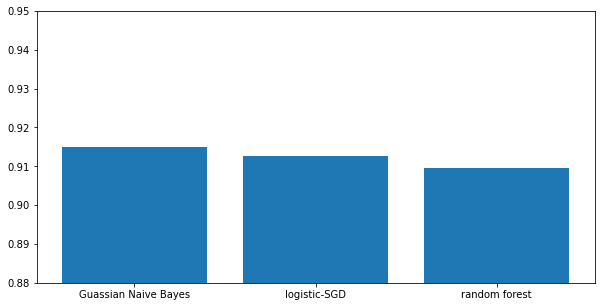

In [36]:
plt.figure(figsize=(10,5))
plt.bar(x, All_f1s)
plt.xticks(x, model_names)
plt.ylim(0.88,0.95)   # allowing to see the difference better
plt.show()

While we have quite satisfactory results from linear classification models, lets examine neural networks to see if we can build an even better model than the Gaussian Naive Bayes.

### 9. Shallow Neural Network Model



In [37]:
from keras.metrics import BinaryAccuracy,Precision,Recall
def build_SNN_model(n):
    keras.backend.clear_session()
    
    model=Sequential()
    model.add(Dense(4,activation='tanh',input_shape=(n,)))
    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
                 loss = losses.binary_crossentropy,
                 metrics=[BinaryAccuracy(),Precision(thresholds=0.5),Recall(thresholds=0.5)])
    
    return model

snnmodel = build_SNN_model(X_train_processed.shape[1])
snnmodel.summary()
history = snnmodel.fit(X_train_processed,y_train,epochs=500,batch_size=32,verbose=0, validation_split=0.1)
#print(history.history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [38]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

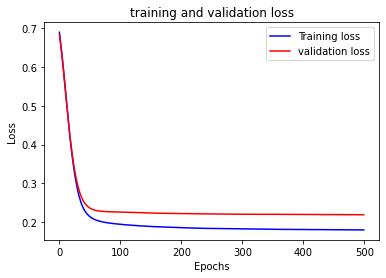

In [39]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(loss,'b',label='Training loss')
ax1.plot(val_loss,'r',label='validation loss')
ax1.set_title('training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
_=plt.show()

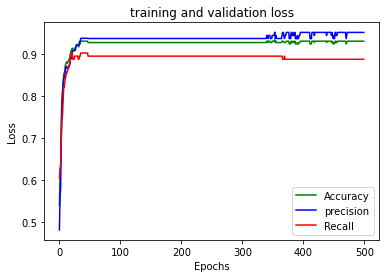

In [40]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(val_acc,'g',label='Accuracy')
ax2.plot(val_precision,'b',label='precision')
ax2.plot(val_recall,'r',label='Recall')
ax2.set_title('training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
_=plt.show()

In [41]:
p_train = snnmodel.predict(X_train_processed)
h_train = np.array([int(elem) for elem in p_train>0.5])

p_test = snnmodel.predict(X_test_processed)
h_test = np.array([int(elem) for elem in p_test>0.5])

ca_train = accuracy_score(np.squeeze(y_train),np.squeeze(h_train))
ca_test = accuracy_score(np.squeeze(y_test),np.squeeze(h_test))

print("training accuracy: {0:0.2%}".format(ca_train))
print("training accuracy: {0:0.2%}".format(ca_test))

snncf_test = confusion_matrix(y_test,h_test)
snnps=precision_score(y_test,h_test)
snnrs = recall_score(y_test,h_test)
snnf1 = f1_score(y_test,h_test)

print(snncf_test)
print("ps: {0:.2%}".format(snnps))
print("rs: {0:.2%}".format(snnrs))
print("f1: {0:.2%}".format(snnf1))

training accuracy: 92.98%
training accuracy: 91.99%
[[390  18]
 [ 43 311]]
ps: 94.53%
rs: 87.85%
f1: 91.07%


### 10. Deep Neural Networks


In [42]:
def build_DNN_model(n):
    keras.backend.clear_session()
    
    model=Sequential()
    model.add(Dense(5,activation='tanh',input_shape=(n,)))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
                 loss = losses.binary_crossentropy,
                 metrics=[BinaryAccuracy(),Precision(thresholds=0.5),Recall(thresholds=0.5)])
    
    return model

dnnmodel = build_DNN_model(X_train_processed.shape[1])
history = dnnmodel.fit(X_train_processed,y_train,epochs=500,batch_size=32,verbose=0, validation_split=0.1)
#print(history.history)
    

In [43]:
dnnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 50        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

In [44]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

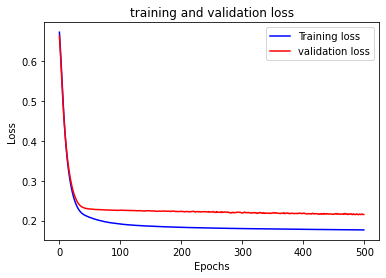

In [45]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(loss,'b',label='Training loss')
ax1.plot(val_loss,'r',label='validation loss')
ax1.set_title('training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
_=plt.show()

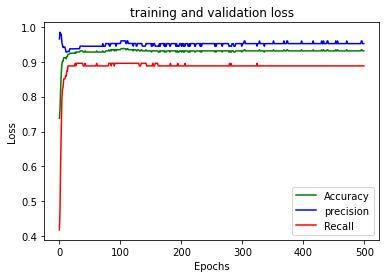

In [46]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(val_acc,'g',label='Accuracy')
ax2.plot(val_precision,'b',label='precision')
ax2.plot(val_recall,'r',label='Recall')
ax2.set_title('training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
_=plt.show()

In [47]:
p_train = dnnmodel.predict(X_train_processed)
h_train = np.array([int(elem) for elem in p_train>0.5])

p_test = dnnmodel.predict(X_test_processed)
h_test = np.array([int(elem) for elem in p_test>0.5])

ca_train = accuracy_score(np.squeeze(y_train),np.squeeze(h_train))
ca_test = accuracy_score(np.squeeze(y_test),np.squeeze(h_test))

print("training accuracy: {0:0.2%}".format(ca_train))
print("training accuracy: {0:0.2%}".format(ca_test))

dnncf_test = confusion_matrix(y_test,h_test)
dnnps=precision_score(y_test,h_test)
dnnrs = recall_score(y_test,h_test)
dnnf1 = f1_score(y_test,h_test)

print(dnncf_test)
print("ps: {0:.2%}".format(dnnps))
print("rs: {0:.2%}".format(dnnrs))
print("f1: {0:.2%}".format(dnnf1))

training accuracy: 93.04%
training accuracy: 92.13%
[[390  18]
 [ 42 312]]
ps: 94.55%
rs: 88.14%
f1: 91.23%


### 10.1 DNN with he-normal and ReLu

In [48]:
def build_DNNHe_model(n):
    keras.backend.clear_session()
    hidden_init = keras.initializers.he_normal(seed=random_seed)
    output_init = keras.initializers.glorot_uniform(seed=random_seed)
    
    model=Sequential()
    model.add(Dense(5,activation='relu',input_shape=(n,),kernel_initializer=hidden_init))
    model.add(Dense(5,activation='relu',kernel_initializer=hidden_init))
    model.add(Dense(5,activation='relu',kernel_initializer=hidden_init))
    model.add(Dense(5,activation='relu',kernel_initializer=hidden_init))
    model.add(Dense(5,activation='relu',kernel_initializer=hidden_init))
    model.add(Dense(5,activation='relu',kernel_initializer=hidden_init))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=output_init))
    
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
                 loss = losses.binary_crossentropy,
                 metrics=[BinaryAccuracy(),Precision(thresholds=0.5),Recall(thresholds=0.5)])
    
    return model

dnnhemodel = build_DNNHe_model(X_train_processed.shape[1])
history = dnnhemodel.fit(X_train_processed,y_train,epochs=500,batch_size=32,verbose=0, validation_split=0.1)
#print(history.history)

In [49]:
dnnhemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 50        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

In [50]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

val_precision = history.history['val_precision']
val_recall = history.history['val_recall']

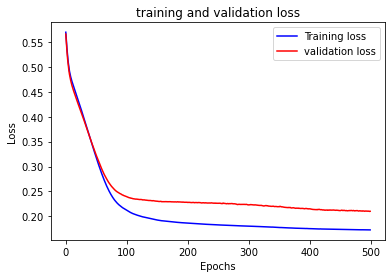

In [51]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(loss,'b',label='Training loss')
ax1.plot(val_loss,'r',label='validation loss')
ax1.set_title('training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
_=plt.show()

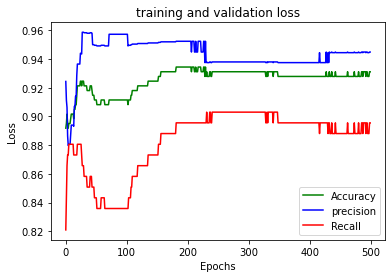

In [52]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(val_acc,'g',label='Accuracy')
ax2.plot(val_precision,'b',label='precision')
ax2.plot(val_recall,'r',label='Recall')
ax2.set_title('training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
_=plt.show()

In [53]:
p_train = dnnhemodel.predict(X_train_processed)
h_train = np.array([int(elem) for elem in p_train>0.5])

p_test = dnnhemodel.predict(X_test_processed)
h_test = np.array([int(elem) for elem in p_test>0.5])

ca_train = accuracy_score(np.squeeze(y_train),np.squeeze(h_train))
ca_test = accuracy_score(np.squeeze(y_test),np.squeeze(h_test))

print("training accuracy: {0:0.2%}".format(ca_train))
print("training accuracy: {0:0.2%}".format(ca_test))

dnnhecf_test = confusion_matrix(y_test,h_test)
dnnheps=precision_score(y_test,h_test)
dnnhers = recall_score(y_test,h_test)
dnnhef1 = f1_score(y_test,h_test)

print(dnnhecf_test)
print("ps: {0:.2%}".format(dnnheps))
print("rs: {0:.2%}".format(dnnhers))
print("f1: {0:.2%}".format(dnnhef1))

training accuracy: 93.04%
training accuracy: 92.52%
[[389  19]
 [ 38 316]]
ps: 94.33%
rs: 89.27%
f1: 91.73%


### 11. Conclusion
Now, lets graph the f1 scores of all classifers including SNN, DNN and DNN-He

In [54]:
x = [1,2,3,4,5,6]

model_names = ["Guassian Naive Bayes","logistic-SGD","random forest",'SNN','DNN TanH','DNN ReLu He']
All_f1s = np.array([gnbf1,
                    sgdf1,
                    rfcf1,
                    snnf1,
                    dnnf1,
                    dnnhef1
                   ])
print("\n\n\n All f1 Scores:")
print(['{:.2%}'.format(item) for item in All_f1s])





 All f1 Scores:
['91.49%', '91.25%', '90.96%', '91.07%', '91.23%', '91.73%']


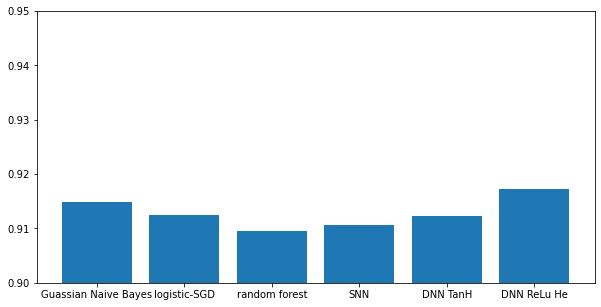

In [55]:
plt.figure(figsize=(10,5))
plt.bar(x, All_f1s)
plt.xticks(x, model_names)
plt.ylim(0.90,0.95)   # allowing to see the difference better
plt.show()

**The best model built is Deep Neural Network with ReLu for hidden layers, and he-normal initializers with f1 score of 91.73%
THe next best is the linear classification model - Gaussian Naive Bayes with f1 score at 91.49%. It can thus be concluded that build_DNNHe_model is the best model built and should be used for production purposes.**